Fast Exact Retrieval for Nearest-neighbor Search

In [1]:
!pip install sortedcontainers matplotlib numpy
import matplotlib.pyplot as plt
import numpy as np
import time
import sys
# from sortedcontainers import SortedDict


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
## Create red black tree datastructure

class VectorNode:
    def __init__(self, vector):
        self.vector = vector
        self.left = None
        self.right = None
        self.parent = None
        self.isRed = True

class VectorTree:
    def __init__(self):
        self.root = VectorNode(None)
        self.root.isRed = False

    def insert(self, vector):
        if self.root is None:
            self.root = VectorNode(vector)
            self.root.isRed = False
        else:
            node = self._insert(vector, self.root)
            # self._fix_tree(node)

    def _insert(self, vector, node):
        if node.left is None:
            node.left = VectorNode(vector)
            node.left.parent = node
            node.left.isRed = True
            return node.left
        elif node.right is None:
            node.right = VectorNode(vector)
            node.right.parent = node
            node.right.isRed = True
            return node.right
        elif self.compare(vector, node.left.vector, node.right.vector)[0] < 0:
            return self._insert(vector, node.left)
        else:
            return self._insert(vector, node.right)

    def retrieve_nearest(self, query):
        """
        Retrieve the nearest (by cosine similarity) neighbor to the given vector.
        """
        # distances = SortedDict()
        # mip is maximum inner product
        mip, mip_vector = sys.float_info.max, None
        curr = None
        queue = [self.root] # queue of VectorNodes to visit
        num_visited = 0

        while queue:
            curr = queue.pop(0)
            num_visited += 1
            if curr is not self.root:
                mip, mip_vector = self.closest(mip, mip_vector, curr.vector, query)
            if curr.left and curr.right:
                lr_dot, can_prune = self.compare(query, curr.left.vector, curr.right.vector)
                if lr_dot <= 0:
                    queue.append(curr.left)
                    if not can_prune: 
                        queue.append(curr.right)
                else:
                    queue.append(curr.right)
                    if not can_prune: 
                        queue.append(curr.left)
            else:
                if curr.left:
                    queue.append(curr.left)
                elif curr.right:
                    queue.append(curr.right)

        return mip_vector, num_visited
    
    def closest(self, min_dist, nn_vector, vector, query):
        vq_dist = self.euclidean_distance(vector, query)
        if vq_dist < min_dist:
            return vq_dist, vector
        return min_dist, nn_vector
    
    def cosine_similarity(self, v1, v2):
        return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

    def euclidean_distance(self, v1, v2):
        return np.linalg.norm(v1 - v2)
        
    def compare(self, query, v1, v2):
        """
            if v1 is closer to query than v2, compare() < 0
        """
        v1v2_dist = self.euclidean_distance(v1, v2) ** 2
        proportion_v2_euc = np.dot(v1-v2, query-v2) / v1v2_dist
        proportion_v1_euc = np.dot(v2-v1, query-v1) / v1v2_dist
        # q_v1_dot = self.cosine_similarity(query, v1)
        # q_v2_dot = self.cosine_similarity(query, v2)
        # proportion_v1_ip = q_v1_dot / (q_v1_dot + q_v2_dot) # proportion of inner product that v1 contributes
        can_prune = proportion_v2_euc < 0.25 or proportion_v2_euc > 0.75 # whether the sub-tree rooted at v1 or v2 can be pruned
        # print("'closeness' of query to v2 vector:", proportion_v2_euc)
        return 0.5 - proportion_v2_euc, can_prune
    


Retrieval times: [4.992485046386719e-05, 0.0001465177536010742, 0.00023241472244262695, 0.0003348979949951172, 0.0005047170639038086, 0.0005340876340866089]
Proportion of vectors traversed: [0.5900000000000001, 0.1515, 0.047852, 0.034066, 0.009798000000000001, 0.00522221]
Recall rate: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


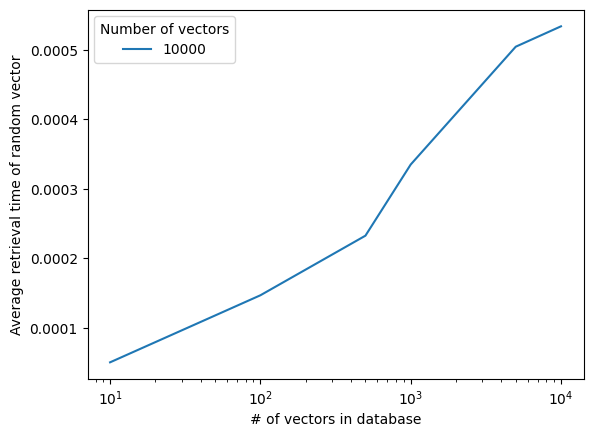

In [8]:
## test
import numpy as np

# create a list of num_vectors
num_vectors = [1, 10, 50, 100, 500, 1000]
num_vectors = [10*e for e in num_vectors]

dim = 3

# create an empty list to store retrieval times for each trial
retrieval_times = []
# avg. proportion of graph traversed per num_vectors item
proportion_traversed = []

# avg. recall per num_vectors item
recalls = []

# for each num_vector
for num_vector in num_vectors:
    # create a VectorTree object
    tree = VectorTree()
    vector_db = [] # list of all vectors

    # insert num_vector random vectors
    for i in range(num_vector):
        vector = np.random.rand(dim)
        vector /= np.linalg.norm(vector)
        # vector = np.random.randint(2, size=dim)
        tree.insert(vector)
        vector_db.append(vector)
    
    # create an empty list to store retrieval times for this num_vector configuration
    retrieval_times_for_selected_vector = []
    num_visited_for_selected_vector = []
    recall_for_selected_vector = []
    # for each retrieval
    for query in vector_db:
        # query = np.random.rand(dim)
        # query /= np.linalg.norm(query)
        # query = np.random.randint(2, size=dim)
        start_time = time.time()
        vector, num_visited = tree.retrieve_nearest(query)
        end_time = time.time()
        # if not np.array_equal(np.array(vector), np.array(selected_vector)):
        #     print("Error")
        retrieval_time = end_time - start_time
        retrieval_times_for_selected_vector.append(retrieval_time)
        num_visited_for_selected_vector.append(num_visited)
        recall_for_selected_vector.append(np.array_equal(np.array(vector), np.array(query)))
        

    retrieval_times.append(sum(retrieval_times_for_selected_vector) / len(retrieval_times_for_selected_vector))
    proportion_traversed.append(sum(num_visited_for_selected_vector) / len(num_visited_for_selected_vector) / num_vector)
    recalls.append(sum(recall_for_selected_vector) / len(recall_for_selected_vector))

print("Retrieval times:", retrieval_times)
print("Proportion of vectors traversed:", proportion_traversed)
print("Recall rate:", recalls)
# plot the average retrieval times for this num_vector
plt.plot(num_vectors, retrieval_times, label=str(num_vector))
    
# set the x-axis label and legend
plt.xlabel('# of vectors in database')
plt.ylabel('Average retrieval time of random vector')
plt.legend(title='Number of vectors')
plt.xscale('log')
plt.show()
